## Inicializacao

In [13]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy.io as sc 
from sympy import symbols, pprint
import matplotlib.pyplot as plt
from structureSelector import *
from methods.utils.utilities import *

def metrics(y, yest):
    residuo1 = y - yest
    index = np.where(y != 0)
    mape = round(np.mean(np.abs(residuo1[index] / y[index])) * 100, 3)
    mse = np.mean(np.square(residuo1))
    rmse = np.sqrt(mse)
    aet = np.sum(np.abs(residuo1))
    print('RMSE:', round(rmse, 4),'\nMSE:', round(mse, 4), '\nAET:', round(aet, 4), '\nMAPE:', str(round(mape, 5)) + '%')
    coeficiente_corr = np.corrcoef(y, yest)[0, 1]
    print("Coeficiente de correlação:", coeficiente_corr)
    #print(y.shape, yest.shape)

dataTank = pd.read_csv('data/coupletanks.csv')
u = np.reshape(np.array(dataTank['u']), (1,-1))
y = np.array(dataTank[['tank1', 'tank2']].T)

## Selecao de estrutura

In [75]:
#Selecione o tanque 
output = 0  # 0 ou 1

num = [3, 5]
params = []
params.append({'nb':[2,2],'na':[12], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':True, 'delay':8, 'diff':False})
params.append({'nb':[0,2],'na':[1], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':True, 'delay':0, 'diff':False})

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output])

vCandidatos = sselector.matrix_candidate(u, y, **params[output], dt=0.1)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, y[output, pad:], num[output], 0.00001)
theta = LSM(y[output, pad:], psi)
model = ss[selected]
print(model, theta)
#print(ss)

[Y1.1 U1.12 sqrtM(Y1.1)] [ 1.00029921  0.02485631 -0.04768864]


### Simulação

In [76]:
slivre = sselector.predict(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)
yhat = sselector.oneStepForward(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output, diff=params[output]['diff'], dt=0.1)


Simulação livre
0 [1]
--------s:  [Y1.1, Y1.2, Y2.1, Y2.2, U1.8, U1.9, U1.10, U1.11, U1.12]



Um passo a frente
RMSE: 0.1325 
MSE: 0.0176 
AET: 247.0589 
MAPE: 3.201%
Coeficiente de correlação: 0.9994921863721219

Simulação livre
RMSE: 0.2193 
MSE: 0.0481 
AET: 431.8361 
MAPE: 5.018%
Coeficiente de correlação: 0.9986202461610603


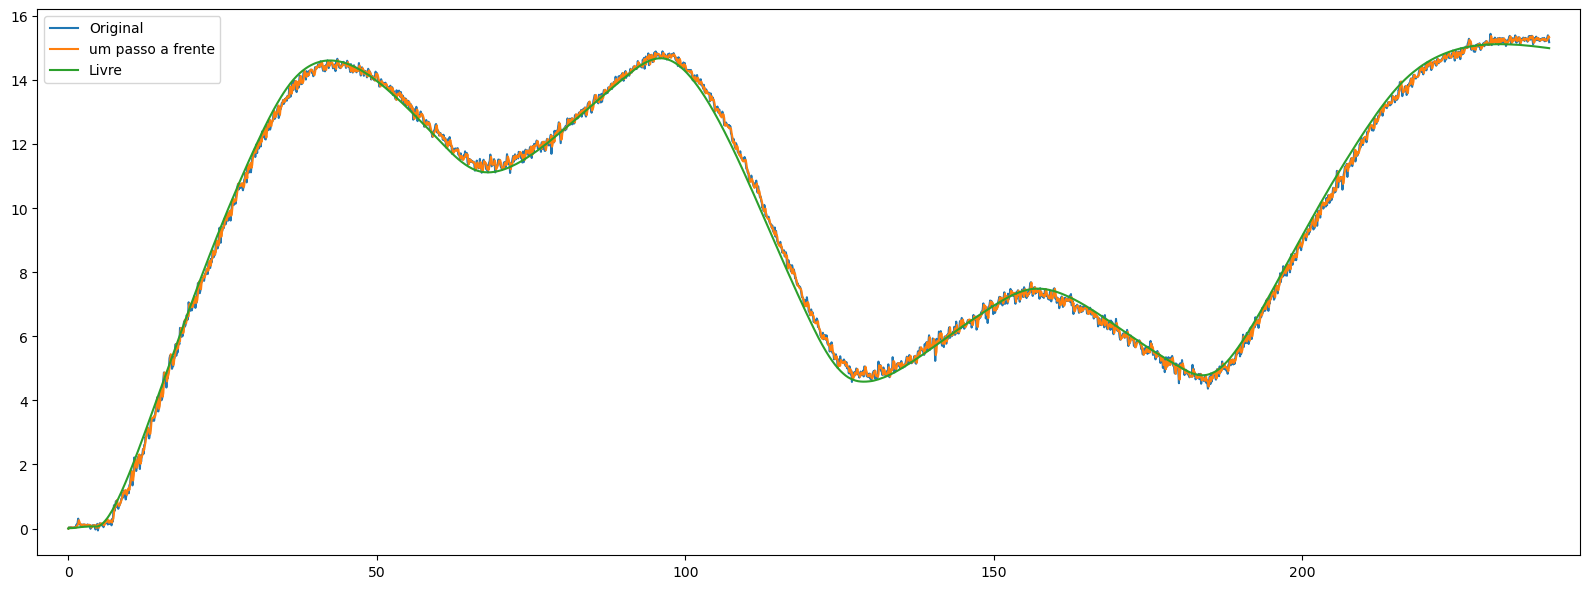

In [51]:

print("\nUm passo a frente")
metrics(y[output], yhat)
print("\nSimulação livre")
metrics(y[output], slivre)

l = 1.5
t = np.arange(0, y[0].shape[0], 1) * 0.1
plt.figure(figsize=(16, 6))
#plt.title("Tanque " + str(output+1))
plt.plot(t, y[output].T, label='Sistema', linewidth=l)
plt.plot(t, yhat, label='um passo a frente', linewidth=l)
plt.plot(t, slivre, label='Livre', linewidth=l)
plt.xlim((-5, 245))
plt.legend()
plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Modelo TCC - Jonh lucas/figuras/tank' + str(1 + output) + 'Est.png')

plt.show()

Simulação livre
1 [0]
--------s:  [Y1.1, Y2.1, Y2.2, U1.0, U1.1]
Simulação livre
1 [0]
--------s:  [Y1.1, Y1.2, Y2.1, Y2.2, U1.0, U1.1, U1.2, U1.3, U1.4]


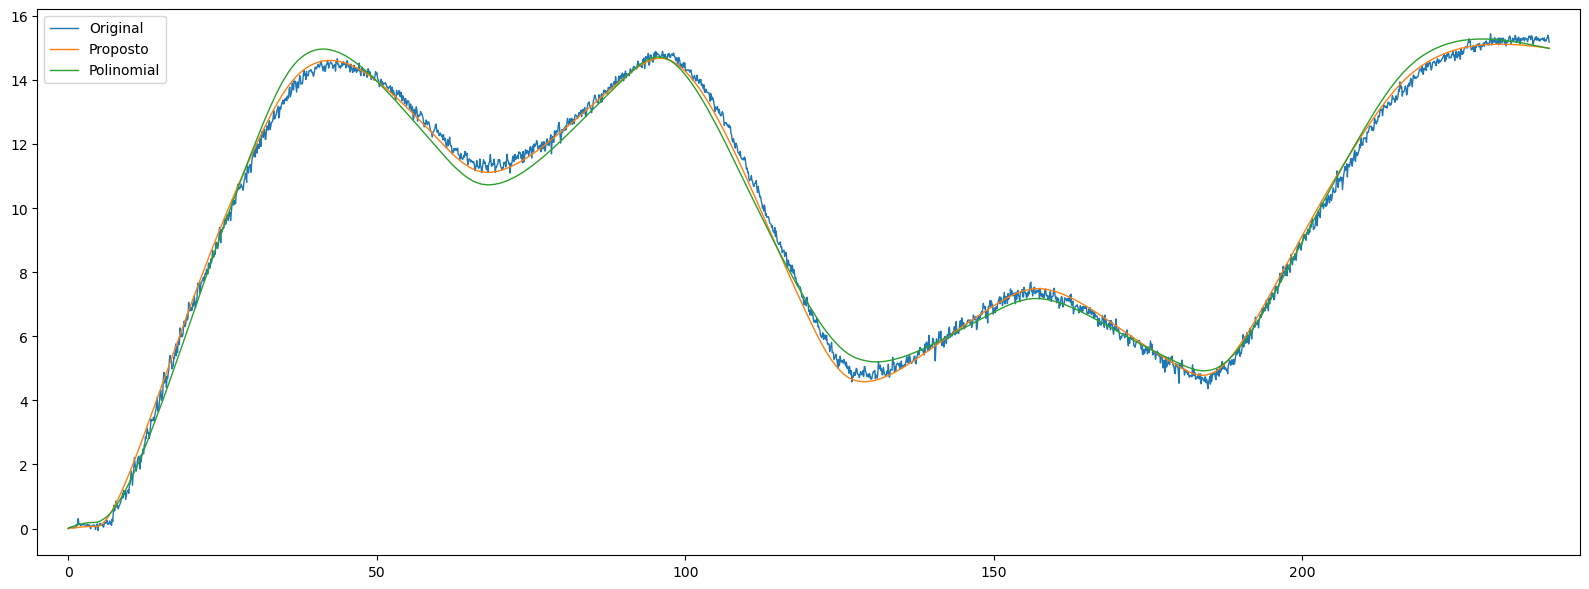

In [55]:
slivre1 = sselector.predict(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)
tt = []
tt.append([ 0.99289921,  0.02485943, -0.07151722]) 
tt.append([ 0.65694291,  0.33397516,  0.0574249,  -0.04870856, -0.00104841])
sm = []
sm.append([symbols("Y1.1"), symbols('U1.12'), ss[0]])
sm.append([symbols("Y2.1"), symbols("Y2.2"), symbols("Y1.1"), symbols("Y1.2"), symbols("U1.2")])

pp = []
pp.append({'nb':[2,2],'na':[15], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':8, 'diff':False})
pp.append({'nb':[2,2],'na':[4], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':0, 'diff':False})

slivre2 = sselector.predict(u, y, tt[output], sm[output], pp[output]['nb'], pp[output]['na'], output, pp[output]['delay'], pp[output]['diff'], dt=0.1)

t = np.arange(0, y[0].shape[0], 1) * 0.1
plt.figure(figsize=(16,6))
plt.plot(t, y[output].T, label='Original', linewidth=1.0)
plt.plot(t, slivre1, label='Proposto', linewidth=1.0)
plt.plot(t, slivre2, label='Polinomial', linewidth=1.0)
plt.xlim((-5,245))
plt.legend()
plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Modelo TCC - Jonh lucas/figuras/compTank2.png')

plt.show()

## Validação

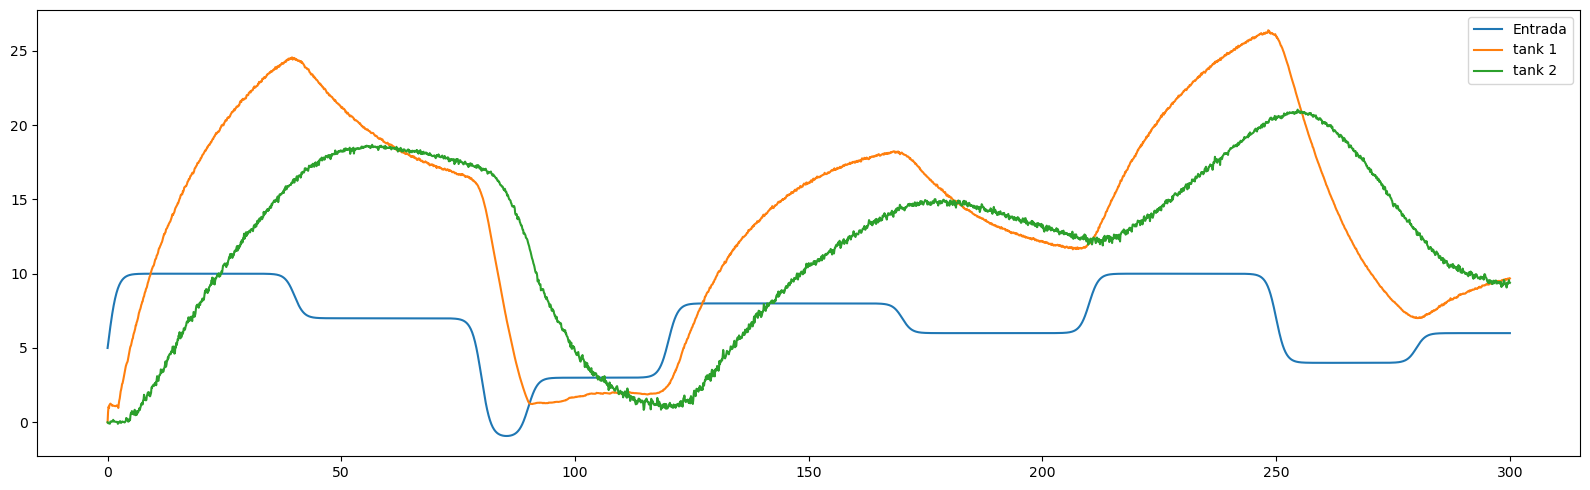

In [53]:
mat_content1 = sc.loadmat("data/ct1x1.mat")
mat_content2 = sc.loadmat("data/ct1x2.mat")

tanque1 = mat_content1['Tanque1']
tanque2 = mat_content2['Tanque2']

t1 = tanque1['time'][0][0]
v1 = tanque1['signals'][0][0]['values'][0][0]

t2 = tanque2['time'][0][0]
v2 = tanque2['signals'][0][0]['values'][0][0]

input = pd.read_csv('data/xinput.csv')
t = input['t']
uVal = np.array(input['v']).reshape((1,-1))


plt.figure(figsize=(16, 5))
plt.plot(t, uVal.T, label='Entrada')
plt.plot(t1, v1, label="tank 1")
plt.plot(t2, v2, label="tank 2")
plt.legend()
plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Modelo TCC - Jonh lucas/figuras/tankVal.png')
plt.show()

(2, 3001)
Simulação livre
1 [0]
--------s:  [Y1.1, Y2.1, Y2.2, U1.0, U1.1]
Modelo selecionado:
0.660203476791626⋅Y2.1 + 0.334519433982439⋅Y2.2 + 0.054831998367799⋅sqrtM(Y1.1
) - 0.0233388789023493⋅sqrtM(Y2.1) - 0.0522616077834017

Um passo a frente
RMSE: 0.1236 
MSE: 0.0153 
AET: 281.2157 
MAPE: 2.501%
Coeficiente de correlação: 0.9997603898251376

Simulação livre
RMSE: 0.5571 
MSE: 0.3104 
AET: 1315.3168 
MAPE: 7.598%
Coeficiente de correlação: 0.9972471856727265


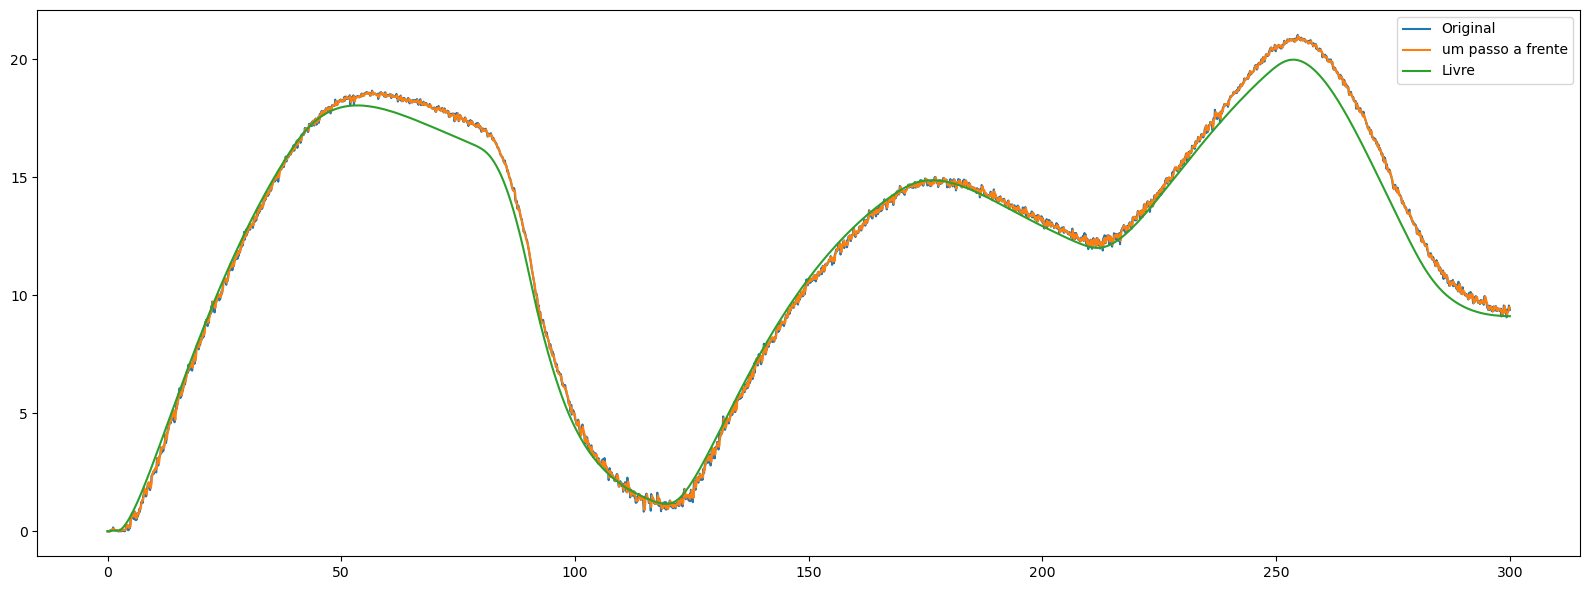

In [58]:
v1[v1 < 0] = 0
v2[v2 < 0] = 0
#v2[:100] = 0
yVal = np.vstack((v1.T, v2.T))
print(yVal.shape)
z = np.zeros(yVal.shape)
valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
yhat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)

print("Modelo selecionado:")
pprint( model @ theta)

print("\nUm passo a frente")
metrics(yVal[output].T, yhat)
print("\nSimulação livre")
metrics(yVal[output].T, valLivre)

#f, ax = plt.subplots(1, 1, figsize=[24, 12])
l = 1.5
plt.figure(figsize=(16, 6))
plt.plot(t1, yVal[output].T, label='Original', linewidth=l) #, linewidth=1.0
plt.plot(t1, yhat, label='um passo a frente', linewidth=l)
plt.plot(t1, valLivre, label='Livre', linewidth=l)
#ax[0].set_title("Simulações")
plt.tight_layout() 
plt.legend()
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Modelo TCC - Jonh lucas/figuras/tank1Val.png')


'''ax[1].plot(t1, yVal[output].T - valLivre, label='Livre')
ax[1].plot(t1, yVal[output].T - yhat, label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()'''
plt.show()

Simulação livre
0 [1]
--------s:  [Y1.1, Y1.2, Y2.1, Y2.2, U1.8, U1.9, U1.10, U1.11, U1.12]
Simulação livre
0 [1]
--------s:  [Y1.1, Y1.2, Y2.1, Y2.2, U1.8, U1.9, U1.10, U1.11, U1.12]


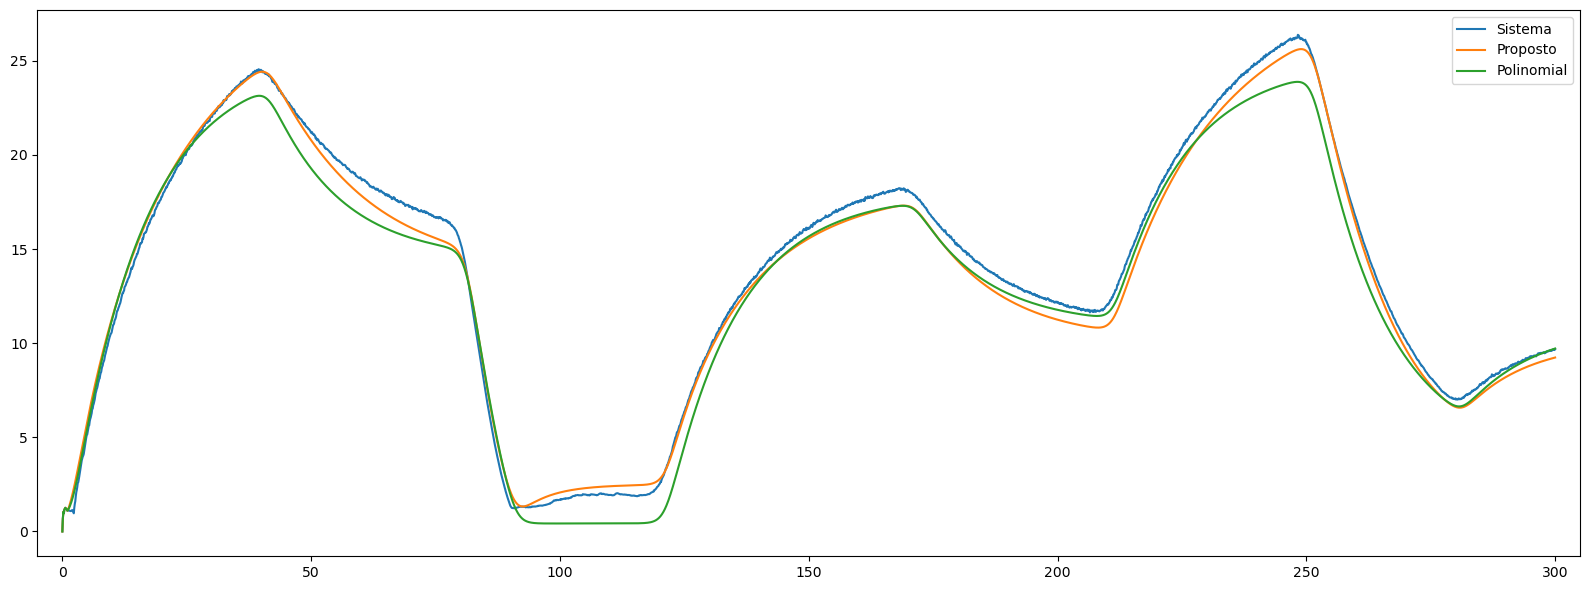

In [48]:
slivre1 = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)
tt = [ 0.99289921,  0.02485943, -0.07151722]
sm = [symbols("Y1.1"), symbols('U1.12'), ss[0]]
slivre2 = sselector.predict(uVal, yVal, tt, sm, params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)

l = 1.5
plt.figure(figsize=(16, 6))
plt.plot(t1, yVal[output].T, label='Sistema', linewidth=l) #
plt.plot(t1, slivre1, label='Proposto', linewidth=l)
plt.plot(t1, slivre2, label='Polinomial', linewidth=l)
plt.xlim((-5, int(t1[-1, 0]) + 5))
plt.legend()
plt.tight_layout() 
plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Modelo TCC - Jonh lucas/figuras/compTank1.png')
plt.show()


Simulação livre
1 [0]
--------s:  [Y1.1, Y2.1, Y2.2, U1.0, U1.1]
Simulação livre
1 [0]
--------s:  [Y1.1, Y1.2, Y2.1, Y2.2, U1.0, U1.1, U1.2, U1.3, U1.4]


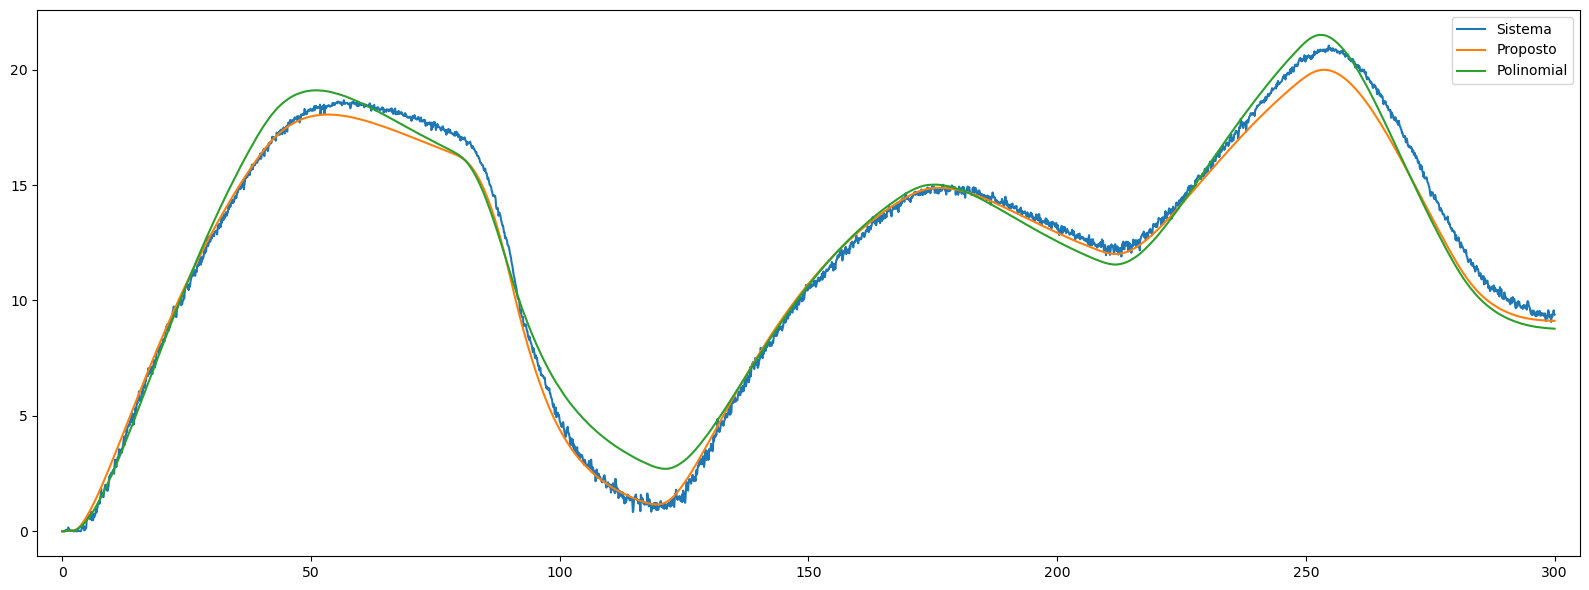

In [74]:
slivre1 = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)
tt = []
tt.append([ 0.99289921,  0.02485943, -0.07151722]) 
tt.append([ 0.65694291,  0.33397516,  0.0574249,  -0.04870856, -0.00104841])
sm = []
sm.append([symbols("Y1.1"), symbols('U1.12'), ss[0]])
sm.append([symbols("Y2.1"), symbols("Y2.2"), symbols("Y1.1"), symbols("Y1.2"), symbols("U1.2")])

pp = []
pp.append({'nb':[2,2],'na':[15], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':8, 'diff':False})
pp.append({'nb':[2,2],'na':[4], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':0, 'diff':False})

slivre2 = sselector.predict(uVal, yVal, tt[output], sm[output], pp[output]['nb'], pp[output]['na'], output, pp[output]['delay'], pp[output]['diff'], dt=0.1)

l = 1.5
t = np.arange(0, yVal.shape[1], 1) * 0.1
plt.figure(figsize=(16,6))
plt.plot(t, yVal[output].T, label='Sistema', linewidth=l)
plt.plot(t, slivre1, label='Proposto', linewidth=l)
plt.plot(t, slivre2, label='Polinomial', linewidth=l)
plt.xlim((-5, yVal.shape[1] / 10 + 5))
plt.legend()
plt.tight_layout() 
plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Modelo TCC - Jonh lucas/figuras/compTank'+str(output + 1)+'.png')

plt.show()

In [63]:
yVal.shape

(2, 3001)